In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import pickle
import os

In [2]:
# ==========================================
# LOAD PREPROCESSED DATA
# ==========================================
print("=" * 70)
print("LOADING PREPROCESSED DATA")
print("=" * 70)

data_dir = 'Data/preprocessed'

# Load preprocessing info
with open(f'{data_dir}/preprocess_info.pkl', 'rb') as f:
    preprocess_info = pickle.load(f)

# Load all preprocessed arrays
train_input_xyz = np.load(f'{data_dir}/train_input_xyz.npy')
train_scalars = np.load(f'{data_dir}/train_scalars.npy')
train_scalars_norm = np.load(f'{data_dir}/train_scalars_norm.npy')

test_input_xyz = np.load(f'{data_dir}/test_input_xyz.npy')
test_scalars = np.load(f'{data_dir}/test_scalars.npy')
test_scalars_norm = np.load(f'{data_dir}/test_scalars_norm.npy')

# Load normalization statistics
stats = np.load(f'{data_dir}/normalization_stats.npz')
scalar_min = stats['scalar_min']
scalar_max = stats['scalar_max']

# Extract metadata
train_idx = preprocess_info['train_idx']
test_idx = preprocess_info['test_idx']
scalar_columns = preprocess_info['scalar_columns']

print(f"\n✅ Data loaded successfully!")
print(f"   Train samples: {len(train_scalars)}")
print(f"   Test samples: {len(test_scalars)}")
print(f"   Input shape: {train_input_xyz.shape}")
print(f"   Scalar shape: {train_scalars.shape}")

# Print scalar statistics
print(f"\nSCALAR STATISTICS (ORIGINAL SCALE):")
scalar_names = ['Max Stress (MPa)', 'Mass (kg)', '1st Freq (Hz)']
for i, col in enumerate(scalar_columns):
    print(f"  {col}:")
    print(f"    Min:  {scalar_min[i]:.6f}")
    print(f"    Max:  {scalar_max[i]:.6f}")
    print(f"    Mean: {train_scalars[:, i].mean():.6f}")
    print(f"    Std:  {train_scalars[:, i].std():.6f}")

# Create normalized tensors
train_scalars_tensor = torch.from_numpy(train_scalars_norm).float()
test_scalars_tensor = torch.from_numpy(test_scalars_norm).float()

print("\n" + "=" * 70)

LOADING PREPROCESSED DATA

✅ Data loaded successfully!
   Train samples: 1684
   Test samples: 421
   Input shape: (1684, 5000, 3)
   Scalar shape: (1684, 3)

SCALAR STATISTICS (ORIGINAL SCALE):
  max_dia_stress(MPa):
    Min:  286.685944
    Max:  1067.449707
    Mean: 543.181885
    Std:  118.700417
  mass(kg):
    Min:  0.561002
    Max:  2.407380
    Mean: 1.234920
    Std:  0.381467
  1st_mode_freq(Hz):
    Min:  752.470276
    Max:  6850.030762
    Mean: 3221.244141
    Std:  1404.028076



In [3]:
class PointNetBaseline(nn.Module):
    def __init__(self):
        super(PointNetBaseline, self).__init__()
        
        # ---------------------------------------------------------
        # 1. Local Feature Extraction (Shared MLP)
        # Input: (Batch, 3, N) -> 3 coords
        # The specific channel sizes are derived from Figure 5 in the paper.
        # ---------------------------------------------------------
        self.conv1 = nn.Conv1d(3, 33, 1)
        self.bn1 = nn.BatchNorm1d(33)
        
        self.conv2 = nn.Conv1d(33, 33, 1)
        self.bn2 = nn.BatchNorm1d(33)
        
        self.conv3 = nn.Conv1d(33, 33, 1)
        self.bn3 = nn.BatchNorm1d(33)
        
        # ---------------------------------------------------------
        # 2. Global Feature Extraction
        # These layers process the local features before Max Pooling
        # ---------------------------------------------------------
        self.conv4 = nn.Conv1d(33, 67, 1)
        self.bn4 = nn.BatchNorm1d(67)
        
        self.conv5 = nn.Conv1d(67, 542, 1)
        self.bn5 = nn.BatchNorm1d(542)
        
        # ---------------------------------------------------------
        # 3. Field Prediction (Shared MLP after concatenation)
        # Concatenation input size: 542 (Global) + 33 (Local from conv3) = 575
        # ---------------------------------------------------------
        self.conv6 = nn.Conv1d(575, 271, 1)
        self.bn6 = nn.BatchNorm1d(271)
        
        self.conv7 = nn.Conv1d(271, 135, 1)
        self.bn7 = nn.BatchNorm1d(135)
        
        self.conv8 = nn.Conv1d(135, 67, 1)
        self.bn8 = nn.BatchNorm1d(67)
        
        # Final output: 4 channels (ux, uy, uz, von Mises stress)
        self.conv9 = nn.Conv1d(67, 4, 1)

    def forward(self, x):
        # x shape: (Batch, 8, N)
        
        # --- Local Features ---
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_features = F.relu(self.bn3(self.conv3(x))) # Save for concatenation (B, 33, N)
        
        # --- Global Feature Generation ---
        x = F.relu(self.bn4(self.conv4(local_features)))
        x = F.relu(self.bn5(self.conv5(x))) # (B, 542, N)
        
        # Max Pooling over the points (N dimension)
        global_feature = torch.max(x, 2, keepdim=True)[0] # (B, 542, 1)
        
        # Expand global feature to match number of points N
        # (B, 542, 1) -> (B, 542, N)
        global_feature_repeated = global_feature.repeat(1, 1, local_features.size(2))
        
        # --- Concatenation ---
        # Concatenate Global (542) + Local (33) -> (575)
        combined = torch.cat([global_feature_repeated, local_features], dim=1)
        
        # --- Field Prediction ---
        x = F.relu(self.bn6(self.conv6(combined)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        
        # Output Layer with Sigmoid activation as specified in Section 2.3
        x = torch.sigmoid(self.conv9(x))
        
        return x # Output shape: (Batch, 4, N)

In [4]:
# ==========================================
# INSTANTIATE POINTNET MODEL
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

model = PointNetBaseline()
model = model.to(device)

print("\n" + "=" * 70)
print("MODEL ARCHITECTURE")
print("=" * 70)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Device: cuda

MODEL ARCHITECTURE
PointNetBaseline(
  (conv1): Conv1d(3, 33, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(33, 67, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(67, 542, kernel_size=(1,), stride=(1,))
  (bn5): BatchNorm1d(542, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(575, 271, kernel_size=(1,), stride=(1,))
  (bn6): BatchNorm1d(271, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv1d(271, 135, kernel_size=(1,), stride=(1,))
  (bn7): 

In [5]:
# Load the best model
model.load_state_dict(torch.load('Data\weight_data\pointnet_best_model.pth'))
model.eval()

PointNetBaseline(
  (conv1): Conv1d(3, 33, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(33, 67, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(67, 542, kernel_size=(1,), stride=(1,))
  (bn5): BatchNorm1d(542, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(575, 271, kernel_size=(1,), stride=(1,))
  (bn6): BatchNorm1d(271, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv1d(271, 135, kernel_size=(1,), stride=(1,))
  (bn7): BatchNorm1d(135, eps=1e-05, moment

In [6]:
# ==========================================
# EXTRACT LATENT FEATURES FROM TRAINED POINTNET MODEL
# ==========================================
print("=" * 70)
print("EXTRACTING LATENT FEATURES FROM POINTNET")
print("=" * 70)

class PointNetLatent(nn.Module):
    """Extract latent features before the field prediction head"""
    def __init__(self, pointnet_model):
        super().__init__()
        self.conv1 = pointnet_model.conv1
        self.bn1 = pointnet_model.bn1
        self.conv2 = pointnet_model.conv2
        self.bn2 = pointnet_model.bn2
        self.conv3 = pointnet_model.conv3
        self.bn3 = pointnet_model.bn3
        self.conv4 = pointnet_model.conv4
        self.bn4 = pointnet_model.bn4
        self.conv5 = pointnet_model.conv5
        self.bn5 = pointnet_model.bn5

    def forward(self, x):
        # x shape: (B, 3, N)
        # --- Local Features ---
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_features = F.relu(self.bn3(self.conv3(x)))  # (B, 33, N)
        
        # --- Global Feature Generation ---
        x = F.relu(self.bn4(self.conv4(local_features)))
        x = F.relu(self.bn5(self.conv5(x)))  # (B, 542, N)
        
        # Max Pooling over the points (N dimension)
        global_feature = torch.max(x, 2, keepdim=True)[0]  # (B, 542, 1)
        
        # Squeeze to (B, 542)
        global_feature = global_feature.squeeze(-1)
        
        return global_feature

# Create latent extractor
latent_extractor = PointNetLatent(model)
latent_extractor = latent_extractor.to(device)
latent_extractor.eval()

print("✅ Latent extractor created (extracts 542-dim global features)")

EXTRACTING LATENT FEATURES FROM POINTNET
✅ Latent extractor created (extracts 542-dim global features)


In [7]:
# ==========================================
# EXTRACT LATENT FEATURES FOR TRAIN/TEST
# ==========================================
print("\nExtracting latent features for training data...")

# Use preprocessed XYZ data directly
train_input_xyz_tensor = torch.from_numpy(train_input_xyz).float()  # (N_train, 5000, 3)
test_input_xyz_tensor = torch.from_numpy(test_input_xyz).float()    # (N_test, 5000, 3)

# Create dataloaders for feature extraction
batch_size = 8
train_xyz_loader = DataLoader(train_input_xyz_tensor, batch_size=batch_size, shuffle=False)
test_xyz_loader = DataLoader(test_input_xyz_tensor, batch_size=batch_size, shuffle=False)

# Extract train latent features
train_latent_features = []
with torch.no_grad():
    for batch in train_xyz_loader:
        batch = batch.to(device)
        # Transpose to (B, 3, N)
        batch = batch.transpose(1, 2)
        latent = latent_extractor(batch)  # (B, 542)
        train_latent_features.append(latent.cpu().numpy())

train_latent_features = np.concatenate(train_latent_features, axis=0)  # (N_train, 542)

# Extract test latent features
print("Extracting latent features for test data...")
test_latent_features = []
with torch.no_grad():
    for batch in test_xyz_loader:
        batch = batch.to(device)
        batch = batch.transpose(1, 2)
        latent = latent_extractor(batch)  # (B, 542)
        test_latent_features.append(latent.cpu().numpy())

test_latent_features = np.concatenate(test_latent_features, axis=0)  # (N_test, 542)

print(f"\n✅ Latent features extracted!")
print(f"   Train latent: {train_latent_features.shape}")
print(f"   Test latent:  {test_latent_features.shape}")


Extracting latent features for training data...
Extracting latent features for test data...

✅ Latent features extracted!
   Train latent: (1684, 542)
   Test latent:  (421, 542)


In [8]:
# ==========================================
# CREATE SCALAR PREDICTION HEAD
# ==========================================
print("\n" + "=" * 70)
print("TRAINING SCALAR PREDICTION HEAD")
print("=" * 70)

class ScalarHead(nn.Module):
    """MLP head to predict 3 scalars from latent features"""
    def __init__(self, latent_dim=542, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        
        self.fc3 = nn.Linear(hidden_dim // 2, 3)  # Output: [stress, mass, freq]

    def forward(self, latent):
        # latent: (B, 542)
        x = F.relu(self.bn1(self.fc1(latent)))
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=0.2, training=self.training)
        
        # Output: (B, 3) - already in [0, 1] range due to sigmoid on inputs
        output = torch.sigmoid(self.fc3(x))
        
        return output

# Create scalar head
scalar_head = ScalarHead(latent_dim=542, hidden_dim=256)
scalar_head = scalar_head.to(device)

print(f"Scalar head parameters: {sum(p.numel() for p in scalar_head.parameters()):,}")


TRAINING SCALAR PREDICTION HEAD
Scalar head parameters: 173,059


In [9]:
# ==========================================
# TRAINING LOOP
# ==========================================
# Convert to tensors
train_latent_tensor = torch.from_numpy(train_latent_features).float()
test_latent_tensor = torch.from_numpy(test_latent_features).float()

# Create datasets
train_scalar_dataset = TensorDataset(train_latent_tensor, train_scalars_tensor)
test_scalar_dataset = TensorDataset(test_latent_tensor, test_scalars_tensor)

# Dataloaders
batch_size = 8
train_scalar_loader = DataLoader(train_scalar_dataset, batch_size=batch_size, shuffle=True)
test_scalar_loader = DataLoader(test_scalar_dataset, batch_size=batch_size, shuffle=False)

print(f"\nTrain batches: {len(train_scalar_loader)}")
print(f"Test batches: {len(test_scalar_loader)}")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(scalar_head.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=False)

# Training
num_epochs = 300
patience = 40
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
test_losses = []

print("\n" + "=" * 70)
print("TRAINING SCALAR HEAD")
print("=" * 70)

for epoch in range(num_epochs):
    # Training phase
    scalar_head.train()
    train_loss = 0.0
    
    for latent, targets in train_scalar_loader:
        latent = latent.to(device)
        targets = targets.to(device)
        
        outputs = scalar_head(latent)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_scalar_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    scalar_head.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for latent, targets in test_scalar_loader:
            latent = latent.to(device)
            targets = targets.to(device)
            
            outputs = scalar_head(latent)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    test_loss /= len(test_scalar_loader)
    test_losses.append(test_loss)
    
    # Learning rate scheduling
    scheduler.step(test_loss)
    
    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0
        torch.save(scalar_head.state_dict(), 'Data\weight_data\scalar_head_best.pth')
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")
    
    if patience_counter >= patience:
        print(f"\n⚠️  Early stopping at epoch {epoch+1}")
        break

# Load best model
scalar_head.load_state_dict(torch.load('Data\weight_data\scalar_head_best.pth'))

print("\n" + "=" * 70)
print("TRAINING COMPLETED")
print("=" * 70)
print(f"Best test loss: {best_val_loss:.6f}")


Train batches: 211
Test batches: 53


c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



TRAINING SCALAR HEAD
Epoch  20/300 | Train Loss: 0.009474 | Test Loss: 0.008008
Epoch  40/300 | Train Loss: 0.008427 | Test Loss: 0.005436
Epoch  60/300 | Train Loss: 0.007626 | Test Loss: 0.005156
Epoch  80/300 | Train Loss: 0.006681 | Test Loss: 0.005432

⚠️  Early stopping at epoch 99

TRAINING COMPLETED
Best test loss: 0.004849


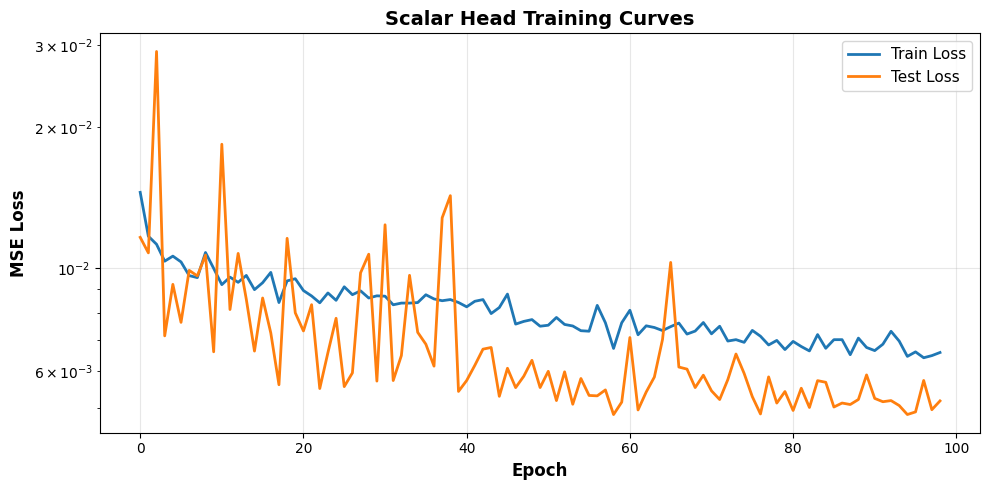


✅ Scalar head training completed and saved!


In [10]:
# ==========================================
# PLOT TRAINING CURVES
# ==========================================
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_losses, label='Train Loss', linewidth=2, color='#1f77b4')
ax.plot(test_losses, label='Test Loss', linewidth=2, color='#ff7f0e')

ax.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax.set_ylabel('MSE Loss', fontweight='bold', fontsize=12)
ax.set_title('Scalar Head Training Curves', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print("\n✅ Scalar head training completed and saved!")

In [11]:
# ==========================================
# EVALUATION: R² SCORES AND PREDICTIONS
# ==========================================
print("=" * 70)
print("EVALUATING SCALAR HEAD")
print("=" * 70)

# Load best model
scalar_head.load_state_dict(torch.load('Data\weight_data\scalar_head_best.pth'))
scalar_head.eval()

EVALUATING SCALAR HEAD


ScalarHead(
  (fc1): Linear(in_features=542, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

In [12]:
# ==========================================
# GET PREDICTIONS ON TRAIN/TEST DATA
# ==========================================
def get_predictions(model, latent_tensor, device):
    """Get normalized predictions from model"""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        # Process in batches
        for i in range(0, len(latent_tensor), 8):
            batch = latent_tensor[i:i+8].to(device)
            pred = model(batch)
            predictions.append(pred.cpu().numpy())
    
    return np.concatenate(predictions, axis=0)

# Get normalized predictions
train_pred_norm = get_predictions(scalar_head, train_latent_tensor, device)  # (N_train, 3)
test_pred_norm = get_predictions(scalar_head, test_latent_tensor, device)    # (N_test, 3)

print(f"Train predictions shape: {train_pred_norm.shape}")
print(f"Test predictions shape: {test_pred_norm.shape}")

Train predictions shape: (1684, 3)
Test predictions shape: (421, 3)


In [13]:
# ==========================================
# DENORMALIZE PREDICTIONS
# ==========================================
# Denormalize: x_true = x_norm * (max - min) + min
train_pred_denorm = train_pred_norm * (scalar_max - scalar_min) + scalar_min
test_pred_denorm = test_pred_norm * (scalar_max - scalar_min) + scalar_min

# Denormalize true values
train_true_denorm = train_scalars  # Already has original values
test_true_denorm = test_scalars    # Already has original values

print("\n✅ Predictions denormalized!")


✅ Predictions denormalized!


In [14]:
# ==========================================
# COMPUTE R² SCORES
# ==========================================
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

scalar_names = ['Max Stress (MPa)', 'Mass (kg)', '1st Freq (Hz)']

print("\n" + "=" * 70)
print("R² SCORES (DENORMALIZED)")
print("=" * 70)

train_r2_scores = []
test_r2_scores = []

print("\nTRAINING DATA:")
for i, name in enumerate(scalar_names):
    r2 = r2_score(train_true_denorm[:, i], train_pred_denorm[:, i])
    rmse = np.sqrt(mean_squared_error(train_true_denorm[:, i], train_pred_denorm[:, i]))
    mae = mean_absolute_error(train_true_denorm[:, i], train_pred_denorm[:, i])
    train_r2_scores.append(r2)
    
    print(f"  {name}:")
    print(f"    R²:   {r2:.6f}")
    print(f"    RMSE: {rmse:.6f}")
    print(f"    MAE:  {mae:.6f}")

print("\nTEST DATA:")
for i, name in enumerate(scalar_names):
    r2 = r2_score(test_true_denorm[:, i], test_pred_denorm[:, i])
    rmse = np.sqrt(mean_squared_error(test_true_denorm[:, i], test_pred_denorm[:, i]))
    mae = mean_absolute_error(test_true_denorm[:, i], test_pred_denorm[:, i])
    test_r2_scores.append(r2)
    
    print(f"  {name}:")
    print(f"    R²:   {r2:.6f}")
    print(f"    RMSE: {rmse:.6f}")
    print(f"    MAE:  {mae:.6f}")


R² SCORES (DENORMALIZED)

TRAINING DATA:
  Max Stress (MPa):
    R²:   0.799524
    RMSE: 53.147617
    MAE:  37.608582
  Mass (kg):
    R²:   0.961223
    RMSE: 0.075118
    MAE:  0.057888
  1st Freq (Hz):
    R²:   0.955920
    RMSE: 294.779950
    MAE:  225.062866

TEST DATA:
  Max Stress (MPa):
    R²:   0.623501
    RMSE: 73.249467
    MAE:  48.359524
  Mass (kg):
    R²:   0.949792
    RMSE: 0.081119
    MAE:  0.060556
  1st Freq (Hz):
    R²:   0.919130
    RMSE: 384.401828
    MAE:  272.764435


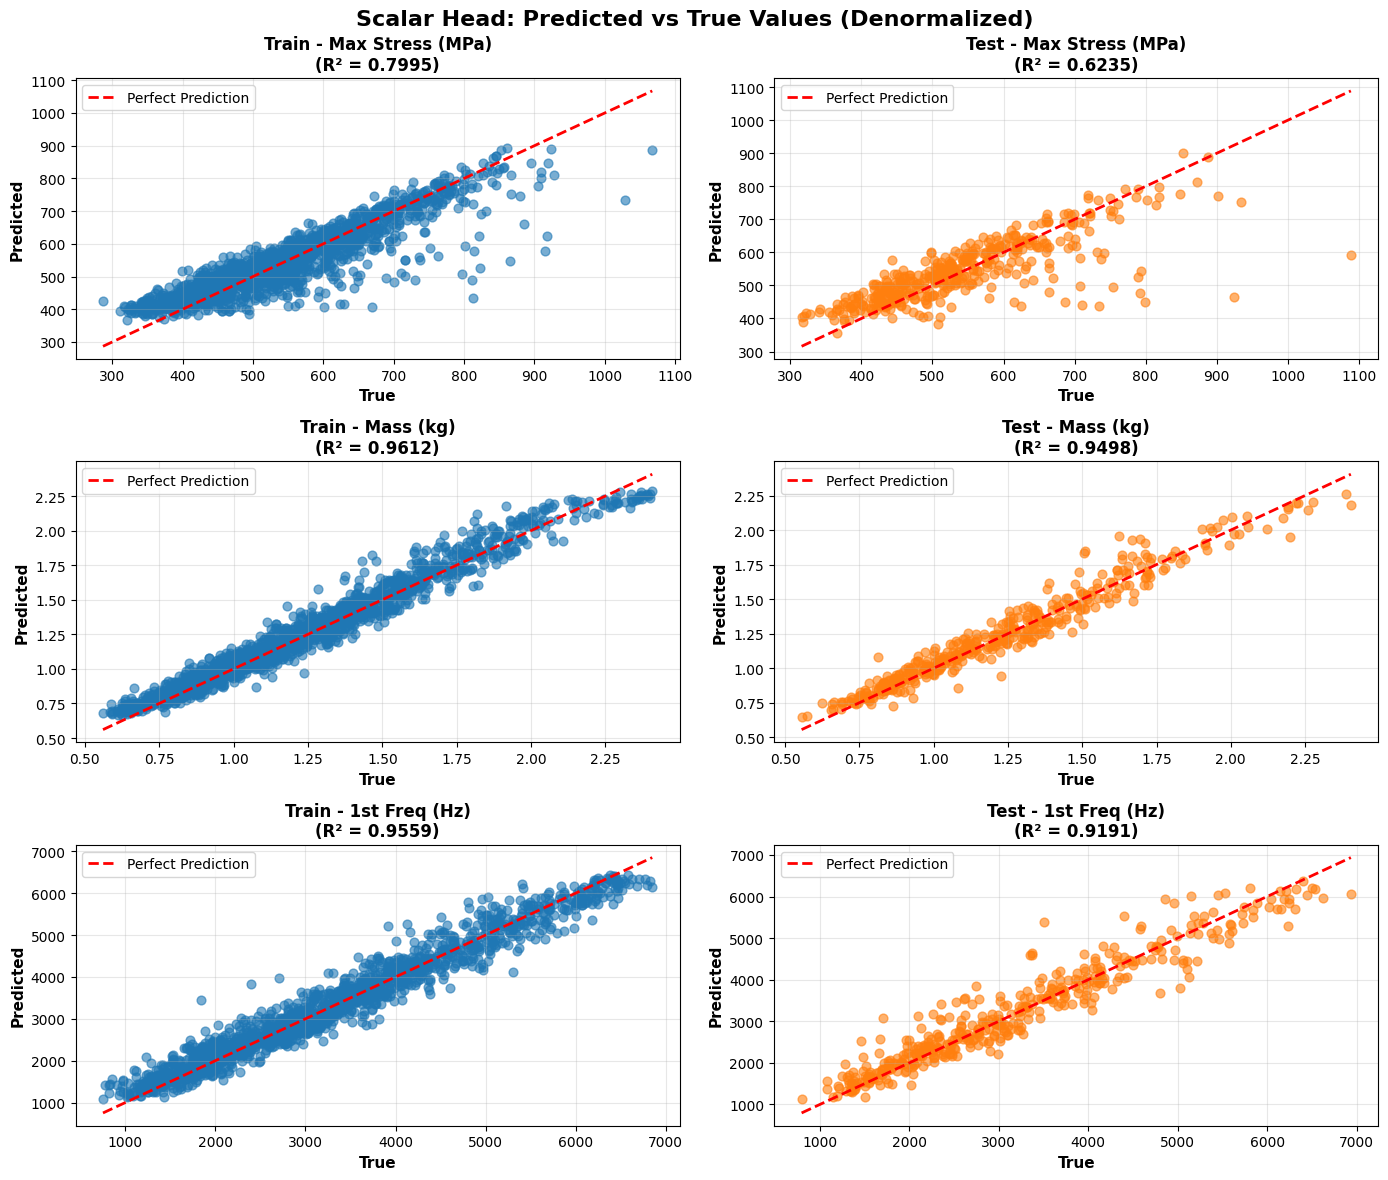

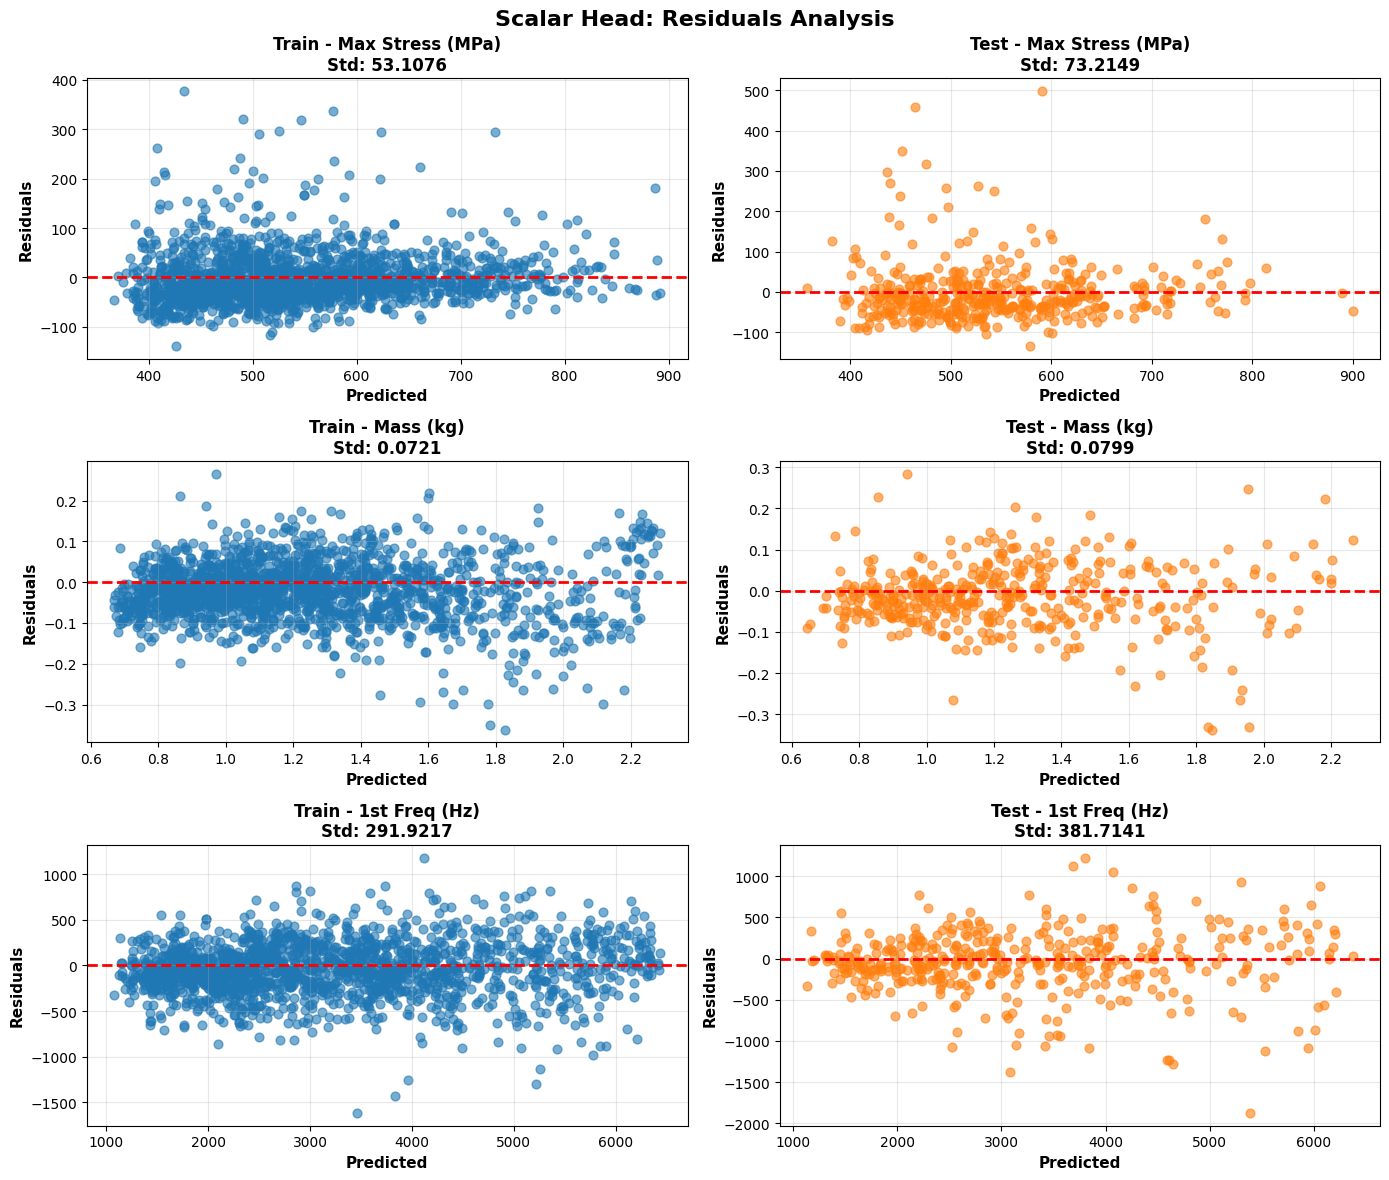


SUMMARY TABLE
          Scalar Train R² Test R² Train RMSE Test RMSE
Max Stress (MPa)   0.7995  0.6235    53.1476   73.2495
       Mass (kg)   0.9612  0.9498     0.0751    0.0811
   1st Freq (Hz)   0.9559  0.9191   294.7799  384.4018


In [15]:
# ==========================================
# PLOT PREDICTIONS VS TRUE (DENORMALIZED)
# ==========================================
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Scalar Head: Predicted vs True Values (Denormalized)', fontsize=16, fontweight='bold')

for i, name in enumerate(scalar_names):
    # TRAIN
    ax = axes[i, 0]
    ax.scatter(train_true_denorm[:, i], train_pred_denorm[:, i], alpha=0.6, s=40, color='#1f77b4')
    
    # Plot perfect prediction line
    min_val = min(train_true_denorm[:, i].min(), train_pred_denorm[:, i].min())
    max_val = max(train_true_denorm[:, i].max(), train_pred_denorm[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('True', fontweight='bold', fontsize=11)
    ax.set_ylabel('Predicted', fontweight='bold', fontsize=11)
    ax.set_title(f'Train - {name}\n(R² = {train_r2_scores[i]:.4f})', fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend()
    
    # TEST
    ax = axes[i, 1]
    ax.scatter(test_true_denorm[:, i], test_pred_denorm[:, i], alpha=0.6, s=40, color='#ff7f0e')
    
    # Plot perfect prediction line
    min_val = min(test_true_denorm[:, i].min(), test_pred_denorm[:, i].min())
    max_val = max(test_true_denorm[:, i].max(), test_pred_denorm[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('True', fontweight='bold', fontsize=11)
    ax.set_ylabel('Predicted', fontweight='bold', fontsize=11)
    ax.set_title(f'Test - {name}\n(R² = {test_r2_scores[i]:.4f})', fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# ==========================================
# PLOT RESIDUALS
# ==========================================
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Scalar Head: Residuals Analysis', fontsize=16, fontweight='bold')

for i, name in enumerate(scalar_names):
    train_residuals = train_true_denorm[:, i] - train_pred_denorm[:, i]
    test_residuals = test_true_denorm[:, i] - test_pred_denorm[:, i]
    
    # TRAIN RESIDUALS
    ax = axes[i, 0]
    ax.scatter(train_pred_denorm[:, i], train_residuals, alpha=0.6, s=40, color='#1f77b4')
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicted', fontweight='bold', fontsize=11)
    ax.set_ylabel('Residuals', fontweight='bold', fontsize=11)
    ax.set_title(f'Train - {name}\nStd: {train_residuals.std():.4f}', fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)
    
    # TEST RESIDUALS
    ax = axes[i, 1]
    ax.scatter(test_pred_denorm[:, i], test_residuals, alpha=0.6, s=40, color='#ff7f0e')
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicted', fontweight='bold', fontsize=11)
    ax.set_ylabel('Residuals', fontweight='bold', fontsize=11)
    ax.set_title(f'Test - {name}\nStd: {test_residuals.std():.4f}', fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# SUMMARY TABLE
# ==========================================
print("\n" + "=" * 70)
print("SUMMARY TABLE")
print("=" * 70)

summary_data = []
for i, name in enumerate(scalar_names):
    train_r2 = r2_score(train_true_denorm[:, i], train_pred_denorm[:, i])
    test_r2 = r2_score(test_true_denorm[:, i], test_pred_denorm[:, i])
    
    train_rmse = np.sqrt(mean_squared_error(train_true_denorm[:, i], train_pred_denorm[:, i]))
    test_rmse = np.sqrt(mean_squared_error(test_true_denorm[:, i], test_pred_denorm[:, i]))
    
    summary_data.append({
        'Scalar': name,
        'Train R²': f'{train_r2:.4f}',
        'Test R²': f'{test_r2:.4f}',
        'Train RMSE': f'{train_rmse:.4f}',
        'Test RMSE': f'{test_rmse:.4f}'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("=" * 70)